## Literature

[Ising notes](http://people.math.aau.dk/~kkb/Undervisning/Bayes14/sorenh/docs/ising-notes.pdf)

[A Tutorial on Image Analysis](https://www.researchgate.net/profile/Havard_Rue/publication/245122781_A_Tutorial_on_Image_Analysis/links/551faa860cf2f9c1304df591/A-Tutorial-on-Image-Analysis.pdf?origin=publication_detail)

[Understanding the Metropolis-Hastings Algorithm](http://www.ics.uci.edu/~johnsong/papers/Chib%20and%20Greenberg%20-%20Understanding%20the%20Metropolis-Hastings%20Algorithm.pdf)

In [15]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [3]:
def mode(ndarray, axis=0):
    # Check inputs
    ndarray = np.asarray(ndarray)
    ndim = ndarray.ndim
    if ndarray.size == 1:
        return (ndarray[0], 1)
    elif ndarray.size == 0:
        raise Exception('Cannot compute mode on empty array')
    try:
        axis = range(ndarray.ndim)[axis]
    except:
        raise Exception('Axis "{}" incompatible with the {}-dimension array'.format(axis, ndim))

    # If array is 1-D and numpy version is > 1.9 numpy.unique will suffice
    if all([ndim == 1,
            int(np.__version__.split('.')[0]) >= 1,
            int(np.__version__.split('.')[1]) >= 9]):
        modals, counts = np.unique(ndarray, return_counts=True)
        index = np.argmax(counts)
        return modals[index], counts[index]

    # Sort array
    sort = np.sort(ndarray, axis=axis)
    # Create array to transpose along the axis and get padding shape
    transpose = np.roll(np.arange(ndim)[::-1], axis)
    shape = list(sort.shape)
    shape[axis] = 1
    # Create a boolean array along strides of unique values
    strides = np.concatenate([np.zeros(shape=shape, dtype='bool'),
                                 np.diff(sort, axis=axis) == 0,
                                 np.zeros(shape=shape, dtype='bool')],
                                axis=axis).transpose(transpose).ravel()
    # Count the stride lengths
    counts = np.cumsum(strides)
    counts[~strides] = np.concatenate([[0], np.diff(counts[~strides])])
    counts[strides] = 0
    # Get shape of padded counts and slice to return to the original shape
    shape = np.array(sort.shape)
    shape[axis] += 1
    shape = shape[transpose]
    slices = [slice(None)] * ndim
    slices[axis] = slice(1, None)
    # Reshape and compute final counts
    counts = counts.reshape(shape).transpose(transpose)[slices] + 1

    # Find maximum counts and return modals/counts
    slices = [slice(None, i) for i in sort.shape]
    del slices[axis]
    index = np.ogrid[slices]
    index.insert(axis, np.argmax(counts, axis=axis))
    return sort[index]

# Ising model for binary image denoising

We want to be able to denoise binary images using the Ising model. For this purpose we use MCMC methods such as Gibbs sampling and Metropolis-Hastings.

In [43]:
def neighbourhood(M, coords, colour, n=4):
    """
    Calculates the the quantity:

        beta * same_colours

    where `same_colours` indicate the number
    of neighbours with the same colour as the
    input argument.

    Neighbourhood scheme:

        [[0, 1, 0],
         [1, 0, 1],
         [0, 1, 0]]
    """
    height, width = M.shape
    i, j = coords

    def neighbours(x, y, n=4):
        # Four neighbour scheme
        neighbours = np.array([(x-1, y), (x, y-1), (x+1, y), (x, y+1)])
        # Eight neighbour scheme
        if n >= 8:
            diagonal = np.array([(x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)])
            neighbours = np.vstack([neighbours, diagonal])
        # Twelve neighbour scheme
        if n >= 12:
            extremal = np.array([(x-2, y), (x, y-2), (x+2, y), (x, y+2)])
            neighbours = np.vstack([neighbours, extremal])
        return neighbours

    def boundary(index):
        i, j = index
        # Remove boundary points
        if i < 0 or j < 0:
            return False
        if i >= height or j >= width:
            return False
        return True

    positions = list(filter(boundary, neighbours(i, j, n)))

    neighbour_colours = [M[i, j] for i, j in np.array(positions)]
    same_colours = neighbour_colours.count(colour)

    return same_colours

### Gibbs sampling

In [5]:
def gibbs_ising(Y, n_iter, noise_var=0.3, beta=1):
    """
    Computes a binary output image based on
    input image Y. An Ising model is solved
    locally in order to denoise Y.
    """
    n, m = Y.shape
    X = np.random.randint(0, 2, (n, m))

    history = np.zeros((n_iter+1, n, m))
    history[0] = X

    # Generate a chain of length n_iter
    for k in range(n_iter):
        for i in range(n):
            for j in range(m):
                n_black = neighbourhood_ising(Y, (i, j), 0, beta)
                n_white = neighbourhood_ising(Y, (i, j), 1, beta)

                # Acceptance probability
                p = np.exp(beta*n_black)/(np.exp(beta*n_black) + np.exp(beta*n_white))
                U = np.random.uniform()
                if U < p:
                    X[i,j] = 1
                else:
                    X[i,j] = 0

        history[k+1] = X

    return X, history

### Metropolis-Hastings

In [28]:
def mh_sample(Y, n_iter, noise_var=0.3, beta=1):
    """
    Computes a sample output image based
    from the posterior based on input
    image Y. An Ising model is solved
    locally in order to provide a denoised
    sample of Y.
    """
    n, m = Y.shape
    X = np.random.randint(0, 2, (n, m))

    # Generate a chain of length n_iter
    for k in range(n_iter):
        for i in range(n):
            for j in range(m):
                x_candidate = 1 - X[i,j]
                #x_candidate = np.random.randint(0, 2)

                h           = - 1.0/(2*noise_var) * (Y[i,j] - X[i,j])**2
                h_candidate = - 1.0/(2*noise_var) * (Y[i,j] - x_candidate)**2

                d           = beta * neighbourhood(X, (i, j), X[i,j]) + h
                d_candidate = beta * neighbourhood(X, (i, j), x_candidate) + h_candidate

                # Acceptance probability
                p = np.exp(min(0, d_candidate - d))
                U = np.random.uniform()
                if U < p:
                    X[i,j] = x_candidate

    return X


### Image estimators

In [0]:
def map_estimate(Y, n_iter, T0= 4, noise_var=0.3, beta=1):
    """
    Computes a Maximum A Posteriori (MAP)
    estimate of the true image based on
    an Ising model with input image Y.
    The MAP estimate simulated annealing.
    """

    n, m = Y.shape
    X = np.random.randint(0, 2, (n, m))
    T = T0

    # Generate a chain of length n_iter
    for _ in range(n_iter):
        for i in range(n):
            for j in range(m):
                x_candidate = 1 - X[i,j]

                h = - 1.0/(2*noise_var) * (Y[i,j] - X[i,j])**2
                h_candidate = - 1.0/(2*noise_var) * (Y[i,j] - x_candidate)**2

                d           = neighbourhood_ising(X, (i, j), X[i,j], beta) + h
                d_candidate = neighbourhood_ising(X, (i, j), x_candidate, beta) + h_candidate

                # Acceptance probability
                p = np.exp(min(0, d_candidate - d)/T)
                U = np.random.uniform()
                if U < p:
                    X[i,j] = x_candidate

        T = T0*0.999**(n_iter)
    return X


def mpm_estimate(Y, m = 10, n_iter = 10, noise_var = 0.3, beta = 1):
    """
    Computes the Marginal Posterior Mode (MPM) estimate
    of the true image based on the noisy image Y.
    """
    X = np.array([mh_sample(Y, n_iter, noise_var, beta) for _ in range(m)])
    return mode(X, 0)

The Ising-based Metropolis-Hastings method is applied to the data, in this case a silhouette of a horse.

In [0]:
from skimage import measure
from skimage import data
from skimage.util import random_noise

# How do we estimate this for our model?
variance = 0.3

X = data.horse()
Y = random_noise(X, "gaussian", var=variance)
X = X.astype(int)

In [16]:
X_map = map_estimate(Y, 100)

In [0]:
X_mpm = mpm_estimate(Y, 10, 10)

In [0]:
result = [measure.mse(X,X_map), measure.mse(X,X_mpm)]

## Plots for the report

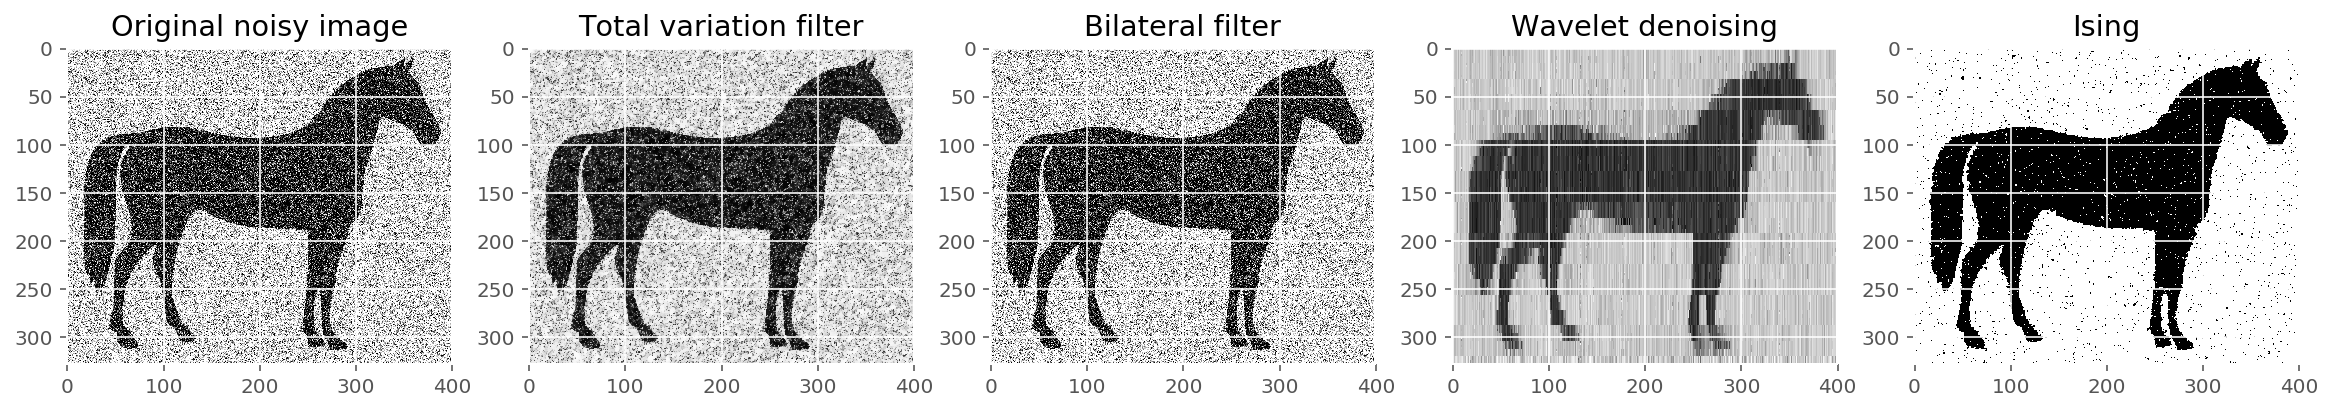

In [9]:
from skimage import restoration

f, axarr = plt.subplots(1, 5, figsize=(20, 20))

axarr[0].imshow(A_prime, cmap="gray")
axarr[0].set_title("Original noisy image")

axarr[1].imshow(restoration.denoise_tv_chambolle(A_prime, weight=0.1, multichannel=False), cmap="gray")
axarr[1].set_title("Total variation filter")

axarr[2].imshow(restoration.denoise_bilateral(A_prime, sigma_color=0.05, sigma_spatial=15, multichannel=False), cmap="gray")
axarr[2].set_title("Bilateral filter")

axarr[3].imshow(restoration.denoise_wavelet(A_prime, multichannel=True), cmap="gray")
axarr[3].set_title("Wavelet denoising")

axarr[4].imshow(X, cmap="gray")
axarr[4].set_title("Ising")


plt.savefig("Comparison.pdf")

In [48]:
arr = np.array([[0, 1, 0, 1, 0],
                [1, 0, 1, 0, 1],
                [0, 1, 0, 1, 0],
                [1, 0, 1, 0, 1],
                [0, 1, 0, 1, 0]])

h = - 1.0/(2*0.3) * (arr[0,0] - arr[1,0])**2
d = 1.0 * neighbourhood(X, (0, 0), (1 - X[1,0])) + h

np.exp(min(0, d-h))

1.0

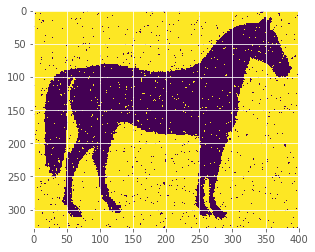

In [30]:
plt.imshow(A)

In [17]:
x = mh_annealing(A, 100, T0=4, noise_var=0.3, beta=1)


In [250]:
from skimage import measure
measure.compare_mse(mode_image, A)

0.00016768292682926831

In [21]:
from skimage import io

scan = io.imread("scan.jpg")